In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive

In [ ]:
cd "My Drive/Practice"

In [193]:
import numpy as np    #numpy for mathematical operation on data
import pandas as pd    # python library to work on data
import datetime         
import os            #module of python provides function for interacting with the operating syestem.
import time             
import matplotlib.pyplot as plt   #for plotting and visual representation of data
import seaborn as sns             #visualisation library based on matplotlib
  #plotting commands just below the code cell 
%matplotlib inline              

In [ ]:

'''from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "TMDB_5000.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')'''

In [194]:
#Loading the tmbd 5000 movies dataset
df1=pd.read_csv('tmdb_5000_credits.csv')
df2=pd.read_csv('tmdb_5000_movies.csv')

In [195]:
df1.head(5)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [196]:
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [197]:
# merging the credits and  movies dataset on 'id'
df1.columns = ['id','title_','cast','crew']
df2= df2.merge(df1,on='id')

In [198]:
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,title_,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [199]:
print(df2.shape);

(4803, 23)


In [200]:
#Demographic Filtering (same for all users)
#Weighted average= (v/(v+m))*R+(m/(v+m))*C
# v-> number of votes
# m-> minimum number of votes to be on the list
# R-> average rating of that movie
# C-> mean of all movie's average rating 
C=df2['vote_average'].mean();
C

6.092171559442011

In [201]:
#Let's decide the value of m
#let's set it to 90 percentile of the vote_count of the movies..
m=df2['vote_count'].quantile(0.9);
m

1838.4000000000015

In [202]:
#Now filter those movies whose vote_count>=m
qualified =df2[df2['vote_count']>=m];
print(qualified.shape);

(481, 23)


In [203]:
# We have 481 movies qualified for being on the chart
# Now calculating our metric i.e, weighted rating
def weighted_rating(x, m=m ,C=C):
  v=x['vote_count'];
  R=x['vote_average'];
  return (v/(v+m))*R+(m/(v+m))*C;

In [204]:
qualified['score']=qualified.apply(weighted_rating,axis=1);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [205]:
qualified.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,title_,cast,crew,score
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.050669
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",6.665696
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",6.239396
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",7.346721
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",6.096368


In [206]:
#sort by scores in descending order
qualified=qualified.sort_values('score',ascending=False);

In [207]:
X=(qualified[['title', 'vote_count', 'vote_average', 'score']].head(10));

In [208]:
# here are our top 10 movies according to vote counts
X

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

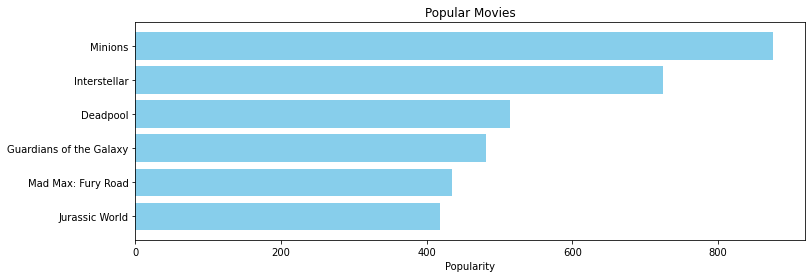

In [209]:
#Let's make a Trending tab for movies that are very popular
#Sorting the dataset according to popularity non-increasing
popular= df2.sort_values('popularity',ascending=False);
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

#using barh to plot horizontal bars for most popular movies
plt.barh(popular['title'].head(6),popular['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


In [210]:
#Content Based Filtering
#movies with similar content (overview,cast,keyword,tag) in same groups

#1. Plot Description based Recommender
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [211]:
#Term Frequency-Inverse Document Frequency (TF-IDF) vectors
# importance of each word in a document= TF*IDF
# tf in a document=  term instance/(total instance)
#inverse document frequency = log(number of documents/ documents with that term)
#using TfIdf vectorizer class of Scikit Learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a','of';
tfidf = TfidfVectorizer(stop_words='english')

df2['overview']=df2['overview'].fillna('')

tfidf_matrix=tfidf.fit_transform(df2['overview']);
print(tfidf_matrix.shape);


(4803, 20978)


In [212]:
tfidf_matrix

<4803x20978 sparse matrix of type '<class 'numpy.float64'>'
	with 125840 stored elements in Compressed Sparse Row format>

In [213]:
#Now we have  20978 words from 4803 movies
#using this we will calculate a similarity score for each pair of movies (here - cosine similarity score)
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix);

In [214]:
cosine_sim.shape

(4803, 4803)

In [215]:
print(cosine_sim)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.02160533 0.         0.        ]
 [0.         0.         1.         ... 0.01488159 0.         0.        ]
 ...
 [0.         0.02160533 0.01488159 ... 1.         0.01609091 0.00701914]
 [0.         0.         0.         ... 0.01609091 1.         0.01171696]
 [0.         0.         0.         ... 0.00701914 0.01171696 1.        ]]


In [216]:
#Constructing a reverse map of indices and movie titles (where we can get index from title of movie)
indices = pd.Series(data=df2.index, index=df2['title']).drop_duplicates()

In [217]:
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [218]:
def get_recommendations(title,cosine_sim=cosine_sim):
  #get the index of that movie
  movie_index=indices[title];

  #make a list of similarity_cosine of that movie with other movies
  sim_score=list(enumerate(cosine_sim[movie_index]))

  #sort the list according to the x[1] i.e the cosine_similarity
  sim_score=sorted(sim_score,key=lambda x:x[1],reverse=True);

  #get first 10 elements
  sim_score=sim_score[1:11]

  #get the movie indices
  movie_indices=[];
  for  i in sim_score:
    movie_indices.append(i[0]);
  return df2['title'].iloc[movie_indices];


In [219]:
X=get_recommendations('Avatar');

In [220]:
X

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title, dtype: object

In [221]:
#Let's improve the performance of syestem by using metadata

#2. credits, genre and keyword based Recommender Syestem
# data is present in stringified list, so need to change them into their particular objects
from ast import literal_eval
feat=['cast','crew','keywords','genres'];
for feature in feat:
  df2[feature]=df2[feature].apply(literal_eval);


In [222]:
print(df2['crew'].iloc[0])

[{'credit_id': '52fe48009251416c750aca23', 'department': 'Editing', 'gender': 0, 'id': 1721, 'job': 'Editor', 'name': 'Stephen E. Rivkin'}, {'credit_id': '539c47ecc3a36810e3001f87', 'department': 'Art', 'gender': 2, 'id': 496, 'job': 'Production Design', 'name': 'Rick Carter'}, {'credit_id': '54491c89c3a3680fb4001cf7', 'department': 'Sound', 'gender': 0, 'id': 900, 'job': 'Sound Designer', 'name': 'Christopher Boyes'}, {'credit_id': '54491cb70e0a267480001bd0', 'department': 'Sound', 'gender': 0, 'id': 900, 'job': 'Supervising Sound Editor', 'name': 'Christopher Boyes'}, {'credit_id': '539c4a4cc3a36810c9002101', 'department': 'Production', 'gender': 1, 'id': 1262, 'job': 'Casting', 'name': 'Mali Finn'}, {'credit_id': '5544ee3b925141499f0008fc', 'department': 'Sound', 'gender': 2, 'id': 1729, 'job': 'Original Music Composer', 'name': 'James Horner'}, {'credit_id': '52fe48009251416c750ac9c3', 'department': 'Directing', 'gender': 2, 'id': 2710, 'job': 'Director', 'name': 'James Cameron'}, 

In [223]:
#Get director name from 'crew' column

def get_director(x):
  for element in x:
    if element['job']=='Director':
      return element['name'];
  return np.nan;    

In [224]:
print(df2['cast'].iloc[0]);

[{'cast_id': 242, 'character': 'Jake Sully', 'credit_id': '5602a8a7c3a3685532001c9a', 'gender': 2, 'id': 65731, 'name': 'Sam Worthington', 'order': 0}, {'cast_id': 3, 'character': 'Neytiri', 'credit_id': '52fe48009251416c750ac9cb', 'gender': 1, 'id': 8691, 'name': 'Zoe Saldana', 'order': 1}, {'cast_id': 25, 'character': 'Dr. Grace Augustine', 'credit_id': '52fe48009251416c750aca39', 'gender': 1, 'id': 10205, 'name': 'Sigourney Weaver', 'order': 2}, {'cast_id': 4, 'character': 'Col. Quaritch', 'credit_id': '52fe48009251416c750ac9cf', 'gender': 2, 'id': 32747, 'name': 'Stephen Lang', 'order': 3}, {'cast_id': 5, 'character': 'Trudy Chacon', 'credit_id': '52fe48009251416c750ac9d3', 'gender': 1, 'id': 17647, 'name': 'Michelle Rodriguez', 'order': 4}, {'cast_id': 8, 'character': 'Selfridge', 'credit_id': '52fe48009251416c750ac9e1', 'gender': 2, 'id': 1771, 'name': 'Giovanni Ribisi', 'order': 5}, {'cast_id': 7, 'character': 'Norm Spellman', 'credit_id': '52fe48009251416c750ac9dd', 'gender': 2

In [225]:
print(df2['keywords'].iloc[0])

[{'id': 1463, 'name': 'culture clash'}, {'id': 2964, 'name': 'future'}, {'id': 3386, 'name': 'space war'}, {'id': 3388, 'name': 'space colony'}, {'id': 3679, 'name': 'society'}, {'id': 3801, 'name': 'space travel'}, {'id': 9685, 'name': 'futuristic'}, {'id': 9840, 'name': 'romance'}, {'id': 9882, 'name': 'space'}, {'id': 9951, 'name': 'alien'}, {'id': 10148, 'name': 'tribe'}, {'id': 10158, 'name': 'alien planet'}, {'id': 10987, 'name': 'cgi'}, {'id': 11399, 'name': 'marine'}, {'id': 13065, 'name': 'soldier'}, {'id': 14643, 'name': 'battle'}, {'id': 14720, 'name': 'love affair'}, {'id': 165431, 'name': 'anti war'}, {'id': 193554, 'name': 'power relations'}, {'id': 206690, 'name': 'mind and soul'}, {'id': 209714, 'name': '3d'}]


In [226]:
print(df2['genres'].iloc[0])

[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 878, 'name': 'Science Fiction'}]


In [227]:
#get the director of each movie from crew
df2['director']=df2['crew'].apply(get_director);

In [228]:
print(df2['director'])

0           James Cameron
1          Gore Verbinski
2              Sam Mendes
3       Christopher Nolan
4          Andrew Stanton
              ...        
4798     Robert Rodriguez
4799         Edward Burns
4800          Scott Smith
4801          Daniel Hsia
4802     Brian Herzlinger
Name: director, Length: 4803, dtype: object


In [229]:
# Get top 3 cast member (if less than all)

def get_feat(x):
  #check if it is list or not
  if isinstance(x,list):
    names=[];
    for element in x:
      names.append(element['name'])
  
    if len(names)>3:
      names=names[:3];
    return names;    
  else:
    return [];

In [230]:
#get the top three cast
df2['cast'] = df2['cast'].apply(get_feat)

In [231]:
#get top three keywords and genres in a list 
df2['keywords'] = df2['keywords'].apply(get_feat)
df2['genres'] = df2['genres'].apply(get_feat)

In [232]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(5)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan,"[dc comics, crime fighter, terrorist]","[Action, Crime, Drama]"
4,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton,"[based on novel, mars, medallion]","[Action, Adventure, Science Fiction]"


In [233]:
#convert all names into lower cases and removes all the spaces between team
#eg Johny Depp and Johny Galecki are different and vectoriser should not count Johny as similar

def modify_data(x):  
  if isinstance(x,list):
    new_x=[]
    for element in x:
      new_x.append(str.lower(element.replace(" ","")));
    return new_x;  
  if isinstance(x,str):
    new_x=str.lower(x.replace(" ",""))
    return new_x;
  else :
    return ' ';  


In [234]:
feat = ['cast', 'keywords', 'director', 'genres']
for feature in feat:
    df2[feature] = df2[feature].apply(modify_data)

In [235]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(5)

,title,cast,director,keywords,genres
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver]",jamescameron,"[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]",goreverbinski,"[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,"[danielcraig, christophwaltz, léaseydoux]",sammendes,"[spy, basedonnovel, secretagent]","[action, adventure, crime]"
3,The Dark Knight Rises,"[christianbale, michaelcaine, garyoldman]",christophernolan,"[dccomics, crimefighter, terrorist]","[action, crime, drama]"
4,John Carter,"[taylorkitsch, lynncollins, samanthamorton]",andrewstanton,"[basedonnovel, mars, medallion]","[action, adventure, sciencefiction]"


In [236]:
#making our metadata soup

def create_soup(x):
  st=' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + x['director'] + ' ' +' '.join(x['genres'])
  return st;

In [237]:
df2['soup'] = df2.apply(create_soup, axis=1) 

In [238]:
print(df2['soup'].iloc[0]);

cultureclash future spacewar samworthington zoesaldana sigourneyweaver jamescameron jamescameron action adventure fantasy


In [239]:
# now applying tf-idf and cosine_similarity on metadata soup
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [240]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_meta = cosine_similarity(count_matrix, count_matrix)

In [241]:
indices = pd.Series(df2.index, index=df2['title'])

In [242]:
get_recommendations('The Dark Knight Rises', cosine_sim_meta)

65               The Dark Knight
119                Batman Begins
1196                The Prestige
4638    Amidst the Devil's Wings
95                  Interstellar
1033                    Insomnia
96                     Inception
3073           Romeo Is Bleeding
3573                     Memento
3326              Black November
Name: title, dtype: object

In [243]:
get_recommendations('The Avengers', cosine_sim_meta)

7                   Avengers: Age of Ultron
1294                               Serenity
26               Captain America: Civil War
79                               Iron Man 2
169      Captain America: The First Avenger
174                     The Incredible Hulk
85      Captain America: The Winter Soldier
4401                    The Helix... Loaded
31                               Iron Man 3
33                    X-Men: The Last Stand
Name: title, dtype: object

In [244]:
#Colloborative Filtering
#use SVD and surprise library to implement SVD
#install surprise library
!pip install surprise


In [245]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate 
reader = Reader()

#used ratings_small from the movies data set (so that we can get users and their rating for movies)
ratings = pd.read_csv('ratings_small.csv')
print(ratings.shape)
print(ratings.head())


(100004, 4)
   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205


In [246]:
#readerclass is used to read custom data set and parse it so that used by library function
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [247]:
data

In [248]:
algo = SVD()
# Run 5-fold cross-validation and then print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8960  0.8942  0.8896  0.8979  0.9018  0.8959  0.0040  
MAE (testset)     0.6914  0.6887  0.6855  0.6939  0.6908  0.6901  0.0028  
Fit time          5.79    5.67    5.84    5.75    5.81    5.77    0.06    
Test time         0.17    0.16    0.17    0.16    0.16    0.16    0.00    


{'fit_time': (5.793094635009766,
  5.669593095779419,
  5.835682153701782,
  5.751615285873413,
  5.813987493515015),
 'test_mae': array([0.69144508, 0.68872288, 0.68549519, 0.69392963, 0.69082274]),
 'test_rmse': array([0.89598185, 0.89424729, 0.88958532, 0.89794779, 0.90177728]),
 'test_time': (0.16544270515441895,
  0.16229557991027832,
  0.16678810119628906,
  0.16211509704589844,
  0.16309881210327148)}

In [249]:
#to fit on complete dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

In [250]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [251]:
#predicted rating of user 1 for movie id 2455
algo.predict(1, 2455)

Prediction(uid=1, iid=2455, r_ui=None, est=2.531542964221689, details={'was_impossible': False})

In [252]:
algo.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.79975235130941, details={'was_impossible': False})

In [253]:
#content based recommender for The Movies Dataset
def convert_int(x):
  try:
    return int(x)
  except:
    return np.nan

In [254]:
#reading the The Movies Dataset (metadata for movies listed in full movie lens dataset)
md = pd.read_csv('movies_metadata.csv')
md.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [255]:
md['genres']

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45466, dtype: object

In [256]:
#reading  links_small  (movie id -- tmdbid)
links_small = pd.read_csv('links_small.csv')
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [257]:
#converting tmbd id into int
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [258]:
md = md.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int');
#only taking those movie which have information in links_small
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 24)

In [259]:
credits = pd.read_csv('credits.csv')
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [260]:
keywords = pd.read_csv('keywords.csv');
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [261]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')


In [262]:
smd = smd.merge(credits, on='id')
smd = smd.merge(keywords, on='id')

In [263]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [264]:
#applying literal_eval to convert into usable python structure
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['genres'] = smd['genres'].apply(literal_eval);

smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [265]:
#making a list of genres from the structure 
smd['genres']=smd['genres'].fillna('[]');
smd['genres'] = smd['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [266]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [267]:
#getting director from crew list
smd['director'] = smd['crew'].apply(get_director)

In [268]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names
    #Return empty list in case of missing/malformed data
    return []

In [269]:
smd['cast']=smd['cast'].apply(get_list)

In [270]:
#list of keywords
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [271]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [272]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    smd[feature] = smd[feature].apply(clean_data)

In [273]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
smd['soup'] = smd.apply(create_soup, axis=1)

In [274]:
#Constructing a reverse map of indices and movie titles (where we can get index from title of movie)
indices=pd.Series(smd['id'],index=smd['title'])

In [275]:
def get_recommendations(title, cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return smd['title'].iloc[movie_indices]

In [276]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [277]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_x = cosine_similarity(count_matrix, count_matrix)

In [278]:
# Reset index of our main DataFrame and construct reverse mapping as before
smd = smd.reset_index()
indices = pd.Series(smd.index, index=smd['title'])

In [279]:
get_recommendations('The Dark Knight',cosine_sim_x)

8031         The Dark Knight Rises
6218                 Batman Begins
7659    Batman: Under the Red Hood
1260                Batman & Robin
1134                Batman Returns
524                         Batman
5809                   Point Blank
6645                   Harsh Times
7561                   Harry Brown
7582                      Defendor
Name: title, dtype: object

In [280]:
#reading links_small
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]

#changed to int (tmdb Id)
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']

#merging id_map with smd on tmdbid of movie
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [281]:
id_map.head()

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0


In [282]:
#id_map with  tmdb id as index
indices_map = id_map.set_index('id')

In [283]:
#hybrid recommender - using content based and collaborative filtering
#input :- user Id and Title of the Movie
#output :-similar movies sorted on the basis of expected rating by that particular user

def hybrid(userId, title):    
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim_x[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:50]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [284]:
#getting recommendation for user 1 who watched Avatar 
hybrid(1, 'Avatar')

,title,vote_count,vote_average,id,est
974,Aliens,3282.0,7.7,679,3.258342
8626,Captain America: The Winter Soldier,5881.0,7.6,100402,3.232442
1241,The Fifth Element,3962.0,7.3,18,3.049979
8401,Star Trek Into Darkness,4479.0,7.4,54138,2.976894
2969,Starman,219.0,6.6,9663,2.946831
8712,Guardians of the Galaxy,10014.0,7.9,118340,2.945503
8865,Star Wars: The Force Awakens,7993.0,7.5,140607,2.913017
648,Independence Day,3334.0,6.7,602,2.882142
2834,Predator,2129.0,7.3,106,2.880178
3999,Vampire Hunter D: Bloodlust,92.0,7.0,15999,2.859482


In [285]:
#getting recommendation for user 500 who watched Avatar 
hybrid(500, 'Avatar')

,title,vote_count,vote_average,id,est
648,Independence Day,3334.0,6.7,602,3.429888
8626,Captain America: The Winter Soldier,5881.0,7.6,100402,3.361965
1241,The Fifth Element,3962.0,7.3,18,3.286793
7088,Star Wars: The Clone Wars,434.0,5.8,12180,3.280580
7705,Alice in Wonderland,8.0,5.4,25694,3.224741
3181,The Time Machine,217.0,7.5,2134,3.216755
8712,Guardians of the Galaxy,10014.0,7.9,118340,3.195807
974,Aliens,3282.0,7.7,679,3.191970
7122,"20,000 Leagues Under the Sea",7.0,6.0,30266,3.181984
7358,Race to Witch Mountain,520.0,5.4,13836,3.136038
